In [4]:
import os
import json
import subprocess
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage.color import rgb2hsv, rgba2rgb, hsv2rgb, rgb2gray, gray2rgb

In [5]:
%matplotlib notebook

In [6]:
# fp = '../data/portrait/th (38).jpeg'
# root = fp.split('/')[-1].split('.')[0]
# root

In [7]:
directory = '../data/faces'
fps = [os.path.join(directory, root) for root in os.listdir(directory)]
fp = np.random.choice(fps)
root = fp.split('/')[-1].split('.')[0]
root

'th (32)'

<IPython.core.display.Javascript object>


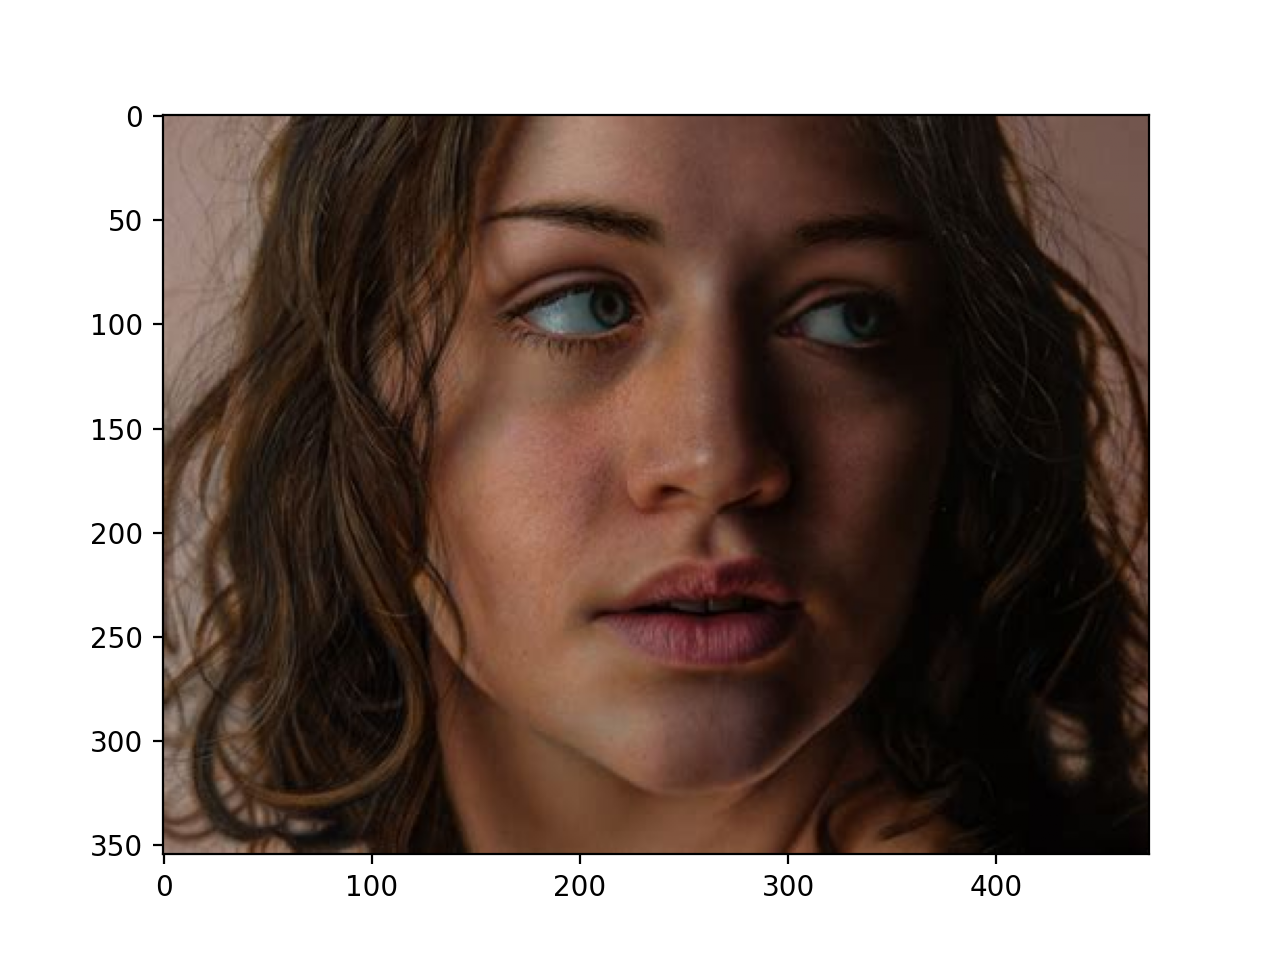

In [8]:
img = skimage.io.imread(fp)

if img.shape[2] == 4:
    img = rgba2rgb(img)
    
if np.max(img) > 1:
    img = img / 255.

hsv_img = rgb2hsv(img)
gray_img = rgb2gray(img)
plt.imshow(img)
plt.show()

In [6]:
annotation_fp = '../data/annotations/th (38).geojson'
d = json.load(open(annotation_fp))
d

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[239, 50],
      [228, 61],
      [228, 62],
      [202, 74],
      [189, 100],
      [181, 88],
      [188, 77],
      [186, 71],
      [179, 72],
      [175, 88],
      [176, 114],
      [183, 121],
      [179, 143],
      [184, 167],
      [174, 196],
      [151, 221],
      [119, 235],
      [90, 252],
      [81, 273],
      [80, 273],
      [77, 295],
      [326, 295],
      [337, 291],
      [330, 261],
      [320, 243],
      [285, 227],
      [249, 213],
      [248, 202],
      [271, 188],
      [305, 143],
      [317, 109],
      [317, 89],
      [309, 78],
      [297, 65],
      [296, 65],
      [295, 64],
      [267, 53],
      [239, 50]]]},
   'properties': {'object_type': 'annotation',
    'classification': {'name': 'skin', 'colorRGB': -493942},
    'isLocked': False}},
  {'type': 'Feature',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[226, 99

In [7]:
def parse_geojson_annotations(d, shape):
    to_return = {}
    for feat in d['features']:
        coords = np.asarray([[y, x] for x, y in feat['geometry']['coordinates'][0]])
        label = feat['properties']['classification']['name']
        
        if label not in to_return:
            to_return[label] = np.full(shape, False)
        poly = skimage.draw.polygon2mask(shape, coords)
        to_return[label] = to_return[label] | poly
    
    return to_return

def get_random_pts_in_mask(mask, size=100):
    pts = np.argwhere(mask)
    idxs = np.random.choice(np.arange(pts.shape[0]), size=size)
    return pts[idxs]

def on_pick(event):
    x, y = event.xdata, event.ydata
    
    ax1.scatter(x, y, s=2, color='black')
    ax3.scatter(x, y, s=2, color='#ab5252')
    
    r, g, b = img[int(y), int(x)]
    ax5.axvline(gray_img[int(y), int(x)] * 256., -.5, 2.5, color=(r, g, b))
    
    h, s, v = hsv_img[int(y), int(x)]
    
    p = 0.01745329 * (h * 360)
    
    x, y = s * np.cos(p), s * np.sin(p)
    
    ax2.scatter(x, y, v, color=(r, g, b))
    ax4.scatter(x, y, color=(r, g, b))
    
    fig.canvas.draw()
    
def add_hues(ax):
    for i in range(0, 360, 5):
        h, s, v = i / 360., 1., 1.
        r, g, b = hsv2rgb(np.asarray([h, s, v]).reshape((1, 1, -1))).flatten()

        p = 0.01745329 * (h * 360)
        x, y = s * np.cos(p), s * np.sin(p)

        ax.scatter(x, y, color=(r, g, b))
        
def plot_pts_on_color_panel(pts, rgb_img, gray_img, figsize=(15, 5)):
    # plot hsv cylinder and circle
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    ax.set_xlim(-1., 1.)
    ax.set_ylim(-1., 1.)
    ax.set_zlim(-1., 1.)
    
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_xlim(-1.1, 1.1)
    ax2.set_ylim(-1.1, 1.1)

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.set_xlim(0., 1.)
    ax3.set_ylim(0., 1.)
    
    add_hues(ax2)

    for pt in pts:
        r, g, b = rgb_img[pt[0], pt[1]]
        h, s, v = hsv_img[pt[0], pt[1]]
        
        p = 0.01745329 * (h * 360)
        
        x, y = s * np.cos(p), s * np.sin(p)
    
        ax.scatter(x, y, v, color=(r, g, b))
        ax2.scatter(x, y, color=(r, g, b))
        ax3.scatter(s, v, color=(r, g, b))

    return fig, [ax, ax2, ax3]

def get_value_rectangle(shape):
    rect = np.zeros(shape)
    rect[:int(shape[0] * .2), :] = 1.
    for c in range(shape[1]):
        rect[:, c] = c / shape[1]
    rect[:int(shape[0] * .2), :] = 1.
    rect[:, 0] = 0.
    rect[:, shape[1] - 1] = 0.
    rect[0, :] = 0.
    rect[shape[0] - 1, :] = 0.


    rect = gray2rgb(rect)

    return rect


def draw_vline_on_img(img, c, color=(1., 0., 0.), width=2):
    img[:, c] = color

    return img


In [8]:
mask_dict = parse_geojson_annotations(d, (img.shape[0], img.shape[1]))

# remove eyes and lips and hair from skin
mask_dict['skin'] = mask_dict['skin'] & ~(mask_dict['eyes'] | mask_dict['lips'] | mask_dict['hair'])
mask_dict.keys()

dict_keys(['skin', 'eyes', 'lips', 'hair'])

In [9]:
mask_dict['skin'].shape

(296, 474)

<IPython.core.display.Javascript object>


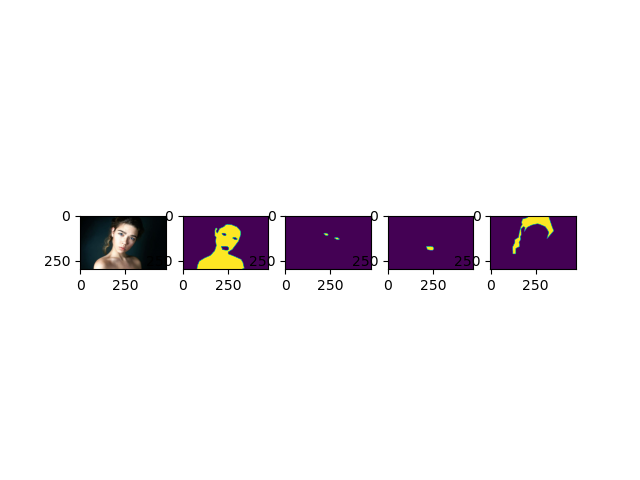

In [10]:
fig, axs = plt.subplots(ncols=len(mask_dict) + 1)
axs[0].imshow(img)
for k, ax in zip(mask_dict.keys(), axs[1:]):
    ax.imshow(mask_dict[k])

#### skin

<IPython.core.display.Javascript object>


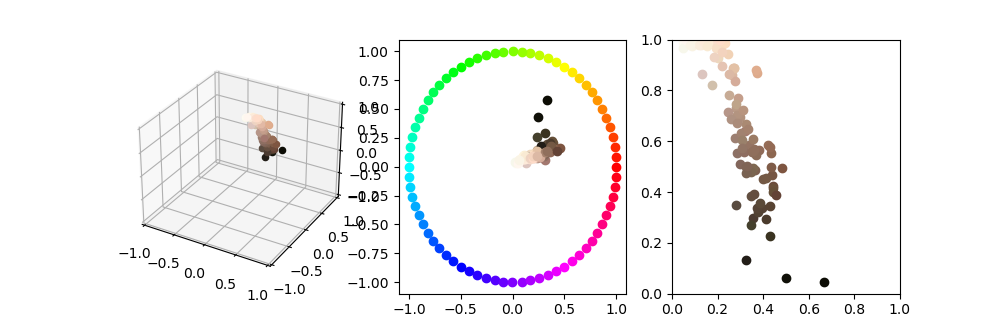

In [11]:
rand_pts = get_random_pts_in_mask(mask_dict['skin'])
fig2, axs2 = plot_pts_on_color_panel(rand_pts, img, gray_img, figsize=(10, 3.3))

<IPython.core.display.Javascript object>


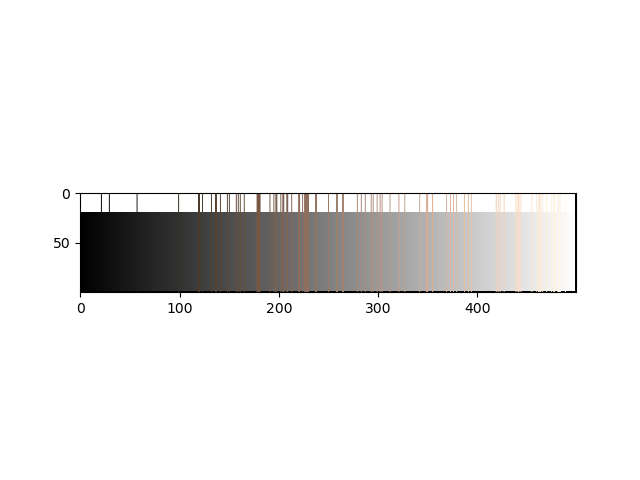

In [12]:
value_rect = get_value_rectangle((100, 500))
for pt in rand_pts:
    c = int(gray_img[pt[0], pt[1]] * value_rect.shape[1] - 1)
    color = img[pt[0], pt[1]]
    draw_vline_on_img(value_rect, c, color=color)
fig, ax = plt.subplots()
ax.imshow(value_rect)